In [6]:
!git clone https://github.com/RTCartist/Neuromorphic-Spatiotemporal-Optical-Flow.git
%cd Neuromorphic-Spatiotemporal-Optical-Flow
%pip install -r requirements.txt


Cloning into 'Neuromorphic-Spatiotemporal-Optical-Flow'...
remote: Enumerating objects: 1124, done.
remote: Total 1124 (delta 0), reused 0 (delta 0), pack-reused 1124 (from 3)
Receiving objects: 100% (1124/1124), 46.05 MiB | 35.32 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/Neuromorphic-Spatiotemporal-Optical-Flow/Neuromorphic-Spatiotemporal-Optical-Flow
ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.9.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88)
ERROR: No matching distribution found for opencv-python==4.9.0


In [7]:
import cv2
import numpy as np
import os
import time
import scipy.io
from numba import njit
import matplotlib.pyplot as plt
import flow_viz

# Data paths for the 'grasp' dataset
RGB_PATH = 'data/grasp/RGB'
MASK_PATH = 'data/grasp/gtmask'
IMGLIST = 'data/grasp/imgs.txt'
MEMMATPATH = 'data/grasp/constructed_3D_matrix.mat'

# Output directory for results
OUTPUT_DIR = 'output/grasp_seg_demo'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Parameters from optical_flow_seg.py
MEMSIZE = 80
OFFSET = 0
EXTEND_HEIGHT_UPPER = 20
EXTEND_HEIGHT_LOWER = 20
EXTEND_WIDTH_LEFT = 20
EXTEND_WIDTH_RIGHT = 20
THRES = 250
CONNECT = 4
FLAG = 2
PADDING = 20
SEG_TH = 1

farneback_params = {
    'pyr_scale': 0.5,
    'levels': 3,
    'winsize': 15,
    'iterations': 3,
    'poly_n': 5,
    'poly_sigma': 1.2,
    'flags': 0
}


In [8]:
@njit
def update_transition_pic(prev_memristor, transition_pic, thres):
    for i in range(prev_memristor.shape[0]):
        for j in range(prev_memristor.shape[1]):
            if prev_memristor[i, j] >= thres:
                transition_pic[i, j] = 255
    return transition_pic

def process_merged_region(stats, rgbimg1, rgbimg2, flow, pixel_width, pixel_height):
    h, w = rgbimg1.shape[:2]
    x_min = min(stats[i, cv2.CC_STAT_LEFT] for i in range(1, len(stats)))
    y_min = min(stats[i, cv2.CC_STAT_TOP] for i in range(1, len(stats)))
    x_max = max(stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH] for i in range(1, len(stats)))
    y_max = max(stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] for i in range(1, len(stats)))

    x_start = max(x_min * pixel_width - EXTEND_WIDTH_LEFT, 0)
    y_start = max(y_min * pixel_height - EXTEND_HEIGHT_UPPER, 0)
    x_end = min(x_max * pixel_width + EXTEND_WIDTH_RIGHT, w)
    y_end = min(y_max * pixel_height + EXTEND_HEIGHT_LOWER, h)

    prev_region = rgbimg1[y_start:y_end, x_start:x_end]
    next_region = rgbimg2[y_start:y_end, x_start:x_end]

    if prev_region.size > 0 and next_region.size > 0:
        current_flow = cv2.calcOpticalFlowFarneback(prev_region, next_region, None, **farneback_params)
        flow[y_start:y_end, x_start:x_end] = current_flow

    return flow, (x_start, y_start, x_end, y_end)

def opticalFlow3D(memimg1, memimg2, rgbimg1, rgbimg2, pixel_width, pixel_height):
    h, w = rgbimg1.shape[:2]
    flow = np.zeros((h, w, 2))

    transition_pic = np.zeros((int(h / pixel_height), int(w / pixel_width)))
    transition_pic = update_transition_pic(memimg2, transition_pic, THRES)
    transition_pic = transition_pic.astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(transition_pic, connectivity=CONNECT)

    if num_labels <= 1:
        return flow, (0,0,0,0), 1

    flow, regions_info = process_merged_region(stats, rgbimg1, rgbimg2, flow, pixel_width, pixel_height)
    return flow, regions_info, num_labels

def process_flow_region(mag, ang):
    region_hsv = np.zeros((*mag.shape, 3), dtype=np.uint8)
    region_hsv[..., 1] = 255
    region_hsv[..., 0] = ang * 180 / np.pi / 2
    region_hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    bgr = cv2.cvtColor(region_hsv, cv2.COLOR_HSV2BGR)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    threshold = SEG_TH
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    motion_mask = np.zeros_like(gray)
    motion_mask[mag > threshold] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    for _ in range(5):
        motion_mask = cv2.dilate(motion_mask, kernel)
        motion_mask = cv2.erode(motion_mask, kernel)

    _, motion_binary = cv2.threshold(motion_mask, 1, 255, cv2.THRESH_BINARY)

    return motion_binary

def task_results(prev_frame, next_frame, flow, num_labels, regions_info):
    h, w = prev_frame.shape[:2]
    motion_binary = np.zeros((h, w), dtype=np.uint8)

    if num_labels > 1:
        x_min, y_min, x_max, y_max = regions_info
        flow_region = flow[y_min:y_max, x_min:x_max]
        mag, ang = cv2.cartToPolar(flow_region[..., 0], flow_region[..., 1])
        motion_binary[y_min:y_max, x_min:x_max] = process_flow_region(mag, ang)

    return motion_binary


In [9]:
with open(IMGLIST, 'r') as f:
    imgs = f.read().splitlines()

mem_data = scipy.io.loadmat(MEMMATPATH)
mem_state = mem_data['constructed3DMatrix']

rgbimages = [os.path.join(RGB_PATH, i) for i in imgs]
rgbimages = sorted(rgbimages, key=lambda x: int(os.path.basename(x).split('.')[0]))

# Let's process the first pair of images
img_idx = 0

mem_state1 = mem_state[:, :, OFFSET + img_idx].astype(np.double)
mem_state2 = mem_state[:, :, OFFSET + img_idx + 1].astype(np.double)

prev_frame = cv2.imread(rgbimages[img_idx])
next_frame = cv2.imread(rgbimages[img_idx + 1])

prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_RGB2GRAY)

with np.errstate(divide='ignore', invalid='ignore'):
    mem_state1_processed = -3366 / np.log10(mem_state1) - 306
mem_state1_processed = np.clip(mem_state1_processed, 0, 255).astype(np.uint8)

with np.errstate(divide='ignore', invalid='ignore'):
    mem_state2_processed = -3366 / np.log10(mem_state2) - 306
mem_state2_processed = np.clip(mem_state2_processed, 0, 255).astype(np.uint8)

memimg1 = mem_state1_processed
memimg2 = mem_state2_processed


In [10]:
pixel_width = MEMSIZE
pixel_height = MEMSIZE

# Calculate neuromorphic optical flow
flow, regions_info, num_labels = opticalFlow3D(memimg1, memimg2, prev_frame_gray, next_frame_gray, pixel_width, pixel_height)
flow = -flow  # Invert for Farneback

# Perform motion segmentation
motion_binary = task_results(prev_frame, next_frame, flow, num_labels, regions_info)

# For comparison, compute standard Farneback optical flow on the full image
full_flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, next_frame_gray, None, **farneback_params)
full_flow = -full_flow


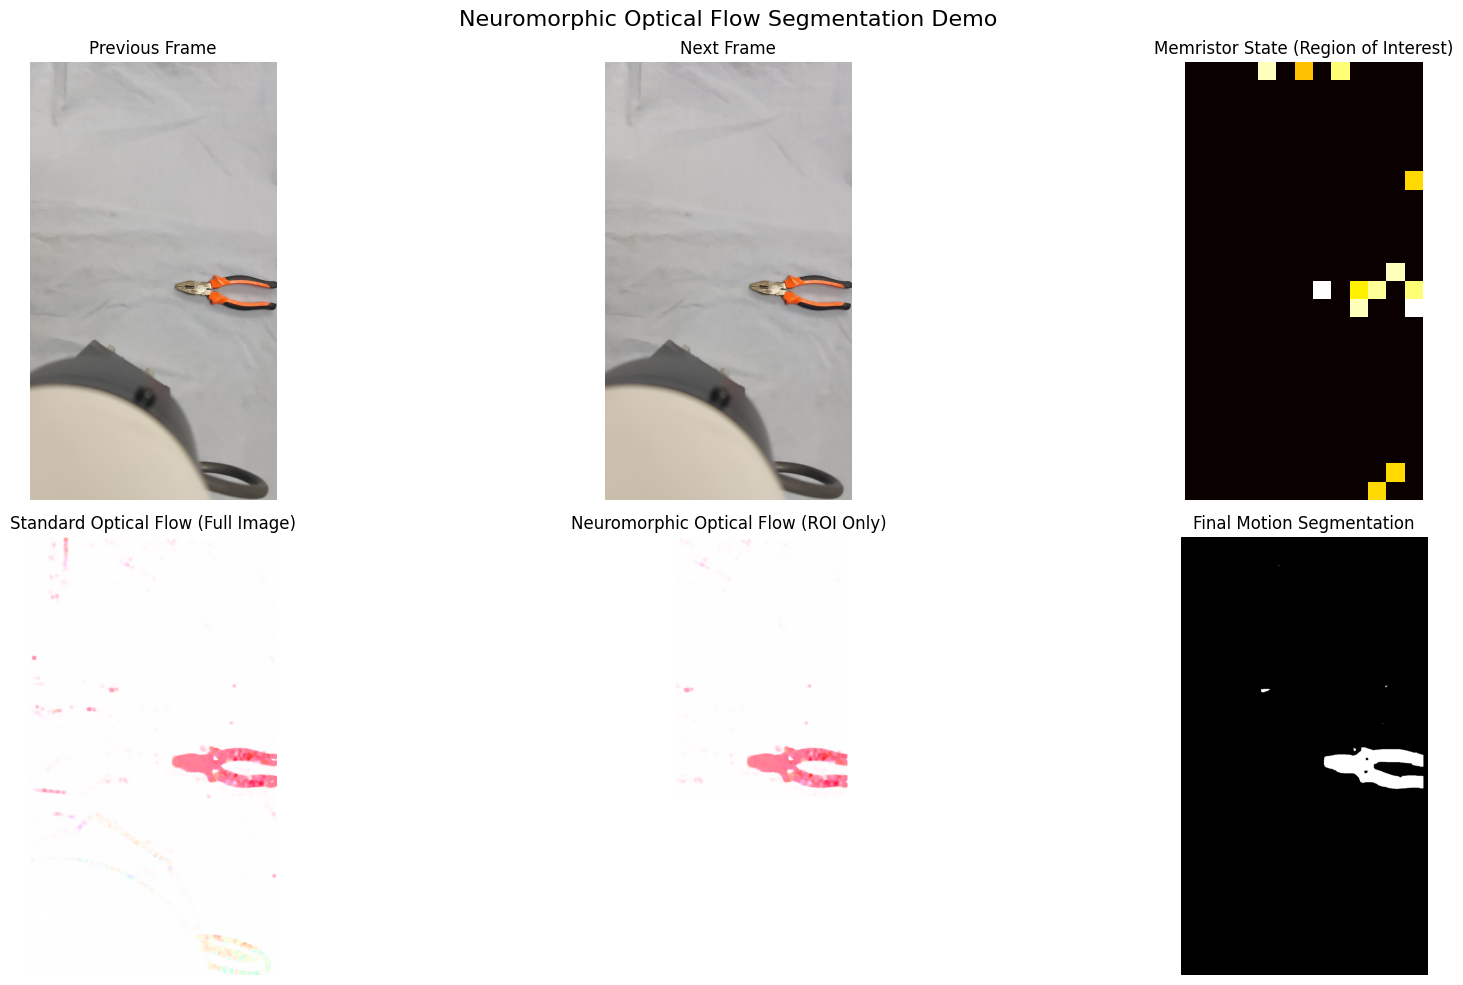

Segmentation mask saved to: output/grasp_seg_demo/segmentation_result.png


In [11]:
# Visualize the results
flow_img = flow_viz.flow_to_image(flow)
full_flow_img = flow_viz.flow_to_image(full_flow)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Neuromorphic Optical Flow Segmentation Demo', fontsize=16)

axes[0, 0].imshow(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Previous Frame')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Next Frame')
axes[0, 1].axis('off')

axes[0, 2].imshow(memimg2, cmap='hot')
axes[0, 2].set_title('Memristor State (Region of Interest)')
axes[0, 2].axis('off')

axes[1, 0].imshow(full_flow_img)
axes[1, 0].set_title('Standard Optical Flow (Full Image)')
axes[1, 0].axis('off')

axes[1, 1].imshow(flow_img)
axes[1, 1].set_title('Neuromorphic Optical Flow (ROI Only)')
axes[1, 1].axis('off')

axes[1, 2].imshow(motion_binary, cmap='gray')
axes[1, 2].set_title('Final Motion Segmentation')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Save the result
output_path = os.path.join(OUTPUT_DIR, 'segmentation_result.png')
cv2.imwrite(output_path, motion_binary)
print(f"Segmentation mask saved to: {output_path}")
